In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data in pandas dataframe

In [5]:
# forecast data for friday in south UK
directory, experiments, inits, cfpf = eun.data.Data.load_meta()
lat, lon = eun.data.Data.get_latlon()
south_df = eun.data.Data.get_friday_data()

In [6]:
south_df.head()

,Unnamed: 0,lat,lon,experiment,cfpf,member,init,time,fg10
0,0,-5.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18 00:00:00,10.980364
1,1,-5.50,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18 00:00:00,10.266060
2,2,-5.25,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18 00:00:00,9.034861
3,3,-5.00,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18 00:00:00,7.949120
4,4,-4.75,52.0,incr,cf,-1,b2nr_2022-02-10,2022-02-18 00:00:00,7.317068


# Cumulative wind gusts and wind gust histograms

In [7]:
# maximum in time for each grid box
max_time = south_df.groupby(['lat', 'lon', 'init', 'member']).max() # inits are different for pi and incr as well
max_time_mean_latlon = max_time.groupby(['experiment','init', 'member']).mean(numeric_only = True)

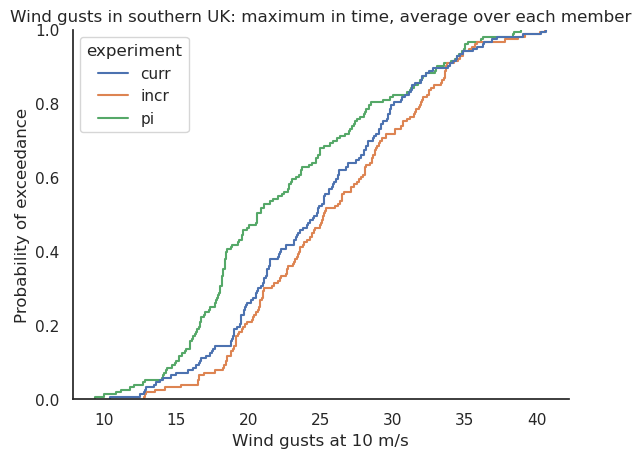

In [8]:
# plot 
sns.ecdfplot(max_time_mean_latlon, x = 'fg10', hue = 'experiment')
plt.xlabel('Wind gusts at 10 m/s')
plt.ylabel('Probability of exceedance')
sns.despine()
plt.title('Wind gusts in southern UK: maximum in time, average over each member')

plt.savefig('figures/03_averaged_cumulative_wind_gusts.pdf')
plt.savefig('figures/03_averaged_cumulative_wind_gusts.png')

Text(0.5, 1.0, 'Wind gusts in southern UK on Friday, 18th Feb')

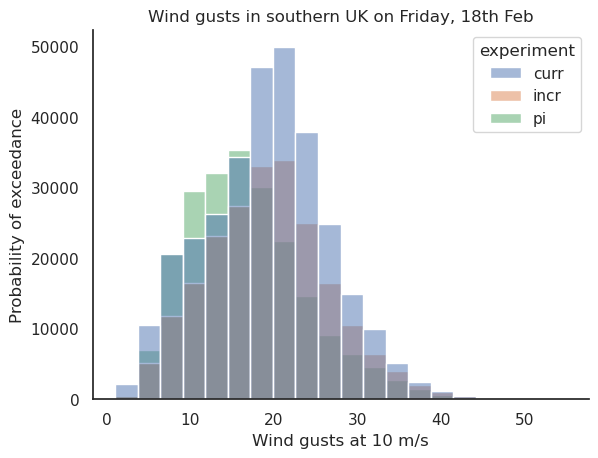

In [9]:
# plot 
south_df['experiment'] = pd.Categorical(south_df['experiment'], ['curr','incr','pi'])
sns.histplot(south_df, x = 'fg10', hue = 'experiment', bins = 20)
plt.xlabel('Wind gusts at 10 m/s')
plt.ylabel('Probability of exceedance')
sns.despine()
plt.title('Wind gusts in southern UK on Friday, 18th Feb')

# Wind gusts by initialisation date

In [10]:
# Reset index from groupby object to variable 
# https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

max_time_mean_latlon_ = max_time_mean_latlon.reset_index()
max_time_mean_latlon_ = max_time_mean_latlon_.assign(init_date = max_time_mean_latlon_.init.str[-10:])

In [11]:
weibull_fits = {}

for experiment in experiments:
    for init in inits[experiment]:
        
        weibull_fits[init] = {'x' : [], 'params' : [], 'rv' : []}
        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init]
        shape, loc, shape1 = stats.weibull_min.fit(data.fg10.values, floc = 10)
        rv_fit = stats.weibull_min(shape, loc, shape1)  # frozen pdf
        weibull_fits[init]['rv'] = rv_fit
        weibull_fits[init]['x'] = np.linspace(rv_fit.ppf(0.01), rv_fit.ppf(0.99), 1000)
        weibull_fits[init]['params'] = [shape, loc, shape1]

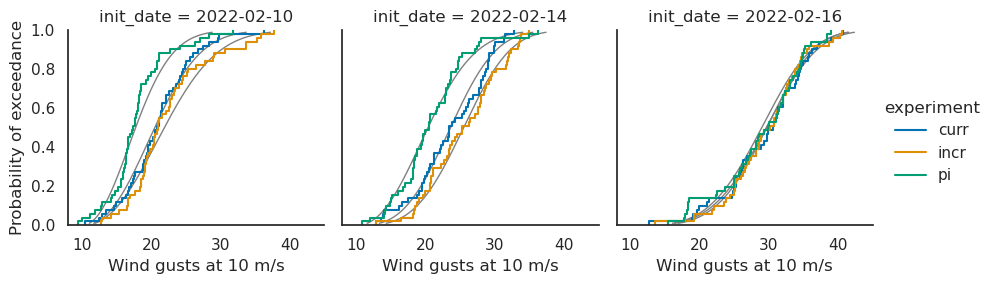

In [12]:
sns.set_palette("colorblind") # could also use palette = sns.color_palette("Paired", 9)
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        #ax.plot(x, rv.cdf(x), color = 'grey', lw = 1)
        sns.lineplot(x = x, y= rv.cdf(x), ax = ax, color = 'grey', lw = 1)
g.map(sns.ecdfplot,'fg10')
g.set_axis_labels("Wind gusts at 10 m/s", "Probability of exceedance")
plt.xlim(8, 45)
g.add_legend()
sns.despine()

### Statistical significance

In [16]:
# bootstrap 1,000 times with samples of size 1,000

init_dates = ['2022-02-10', '2022-02-14', '2022-02-16']
bootstraps = 1000
sample_size = 51

for init_date in init_dates:
    print('Initialisation date: ' ,init_date)
    pis = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'pi')].fg10.values
    currs = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'curr')].fg10.values
    incrs = max_time_mean_latlon_[(max_time_mean_latlon_.init_date == init_date) & (max_time_mean_latlon_.experiment == 'incr')].fg10.values

    # lists for p values
    pi_curr = []
    pi_incr = []
    curr_incr = []

    for i in range(bootstraps):
        pi = np.random.choice(pis, size = sample_size)
        curr = np.random.choice(currs, size = sample_size)
        incr = np.random.choice(incrs, size = sample_size)

        pi_curr.append(stats.kstest(pi, curr)[1])
        pi_incr.append(stats.kstest(pi, incr)[1])
        curr_incr.append(stats.kstest(curr, incr)[1])
    print('PI v CURR: p_se = ', np.std(pi_curr)/np.sqrt(bootstraps), ', full sample: p = ', stats.kstest(pis,currs)[1])
    print('PI v INCR: p_se = ', np.std(pi_incr)/np.sqrt(bootstraps), ', full sample: p = ', stats.kstest(pis,incrs)[1])
    print('CURR v INCR: p_se = ', np.std(curr_incr)/np.sqrt(bootstraps), ', full sample: p = ',stats.kstest(currs, incrs)[1])

Initialisation date:  2022-02-10
PI v CURR: p_se =  0.0005096925989138878 , full sample: p =  4.7712130519607925e-05
PI v INCR: p_se =  0.0001898404944072741 , full sample: p =  6.848631175063338e-07
CURR v INCR: p_se =  0.008283361798844084 , full sample: p =  0.8768119540475026
Initialisation date:  2022-02-14
PI v CURR: p_se =  0.002423739174354418 , full sample: p =  0.0065720003925229765
PI v INCR: p_se =  0.0003792684803346753 , full sample: p =  0.0002962539414562207
CURR v INCR: p_se =  0.006792300730747992 , full sample: p =  0.4083544056661084
Initialisation date:  2022-02-16
PI v CURR: p_se =  0.008370218653190644 , full sample: p =  0.8768119540475026
PI v INCR: p_se =  0.008533454543942111 , full sample: p =  0.8768119540475026
CURR v INCR: p_se =  0.008810251155625186 , full sample: p =  0.9696240652295494


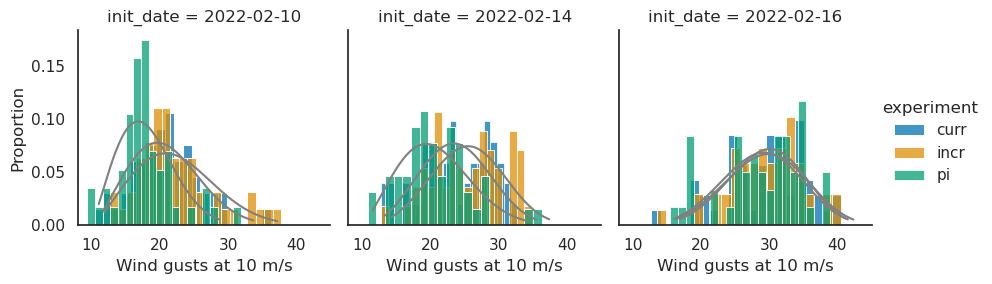

In [14]:
g = sns.FacetGrid(max_time_mean_latlon_, col = 'init_date', hue = 'experiment')
g.map(sns.histplot,'fg10', bins = 20, stat='density')
g.set_axis_labels("Wind gusts at 10 m/s", "Proportion")
for i, ax in enumerate(g.axes_dict.values()):
    for experiment in experiments:
        init = inits[experiment][i]
        x = weibull_fits[init]['x']
        rv = weibull_fits[init]['rv']
        ax.plot(x, rv.pdf(x), color = 'grey')
g.add_legend()
plt.xlim(8, 45)
sns.despine()

# Comparing different distributions

 Weibull (floc = 0,10), generalised logistic, generalised extreme value 

### Cramér von Mises test

In [15]:
weibull_fits0 = {}
weibull_fits10 = {}
gev_fits = {}
gl_fits = {}
bootstraps = 1000
sample_size = 51

args = {'weibull0': [], 'weibull10': [], 'gev': [], 'gl': []}


for experiment in experiments:
    for init in inits[experiment]:
        
        weibull_fits0[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        weibull_fits10[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        gev_fits[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}
        gl_fits[init] = {'p_boot' : [], 'p_full' : [], 'KS_boot' : [], 'KS_full' : []}

        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init]
        args['weibull0'] = stats.weibull_min.fit(data.fg10.values, floc = 0)
        args['weibull10'] = stats.weibull_min.fit(data.fg10.values, floc = 10)
        args['gev'] = stats.genextreme.fit(data.fg10.values)
        args['gl'] = stats.genlogistic.fit(data.fg10.values)
        
        for i in range(bootstraps):
            sample = np.random.choice(data.fg10.values, size = sample_size)
            weibull0_ks = stats.cramervonmises(sample, "weibull_min", args = args['weibull0'])
            weibull10_ks = stats.cramervonmises(sample, "weibull_min", args = args['weibull10'])
            gev_ks = stats.cramervonmises(sample, "genextreme", args = args['gev'])
            gl_ks = stats.cramervonmises(sample, "genlogistic", args = args['gl'])

            weibull_fits0[init]['p_boot'].append(weibull0_ks.pvalue)
            weibull_fits10[init]['p_boot'].append(weibull10_ks.pvalue)
            gev_fits[init]['p_boot'].append(gev_ks.pvalue)
            gl_fits[init]['p_boot'].append(gl_ks.pvalue)

In [16]:
for experiment in experiments:
    print(experiment)
    for init in inits[experiment]:
    #     print(init,' Weibull 0 p = ', np.mean(np.array(weibull_fits0[init]['p_boot'])))
        print(init,' Weibull 10 p = ', np.mean(np.array(weibull_fits10[init]['p_boot'])))
        # print(init,' GEV p = ', np.mean(np.array(gev_fits[init]['p_boot'])))
        # print(init,' GL 0 p = ', np.mean(np.array(gl_fits[init]['p_boot'])))

incr
b2nr_2022-02-10  Weibull 10 p =  0.23117080527192738
b2no_2022-02-14  Weibull 10 p =  0.3393179539981205
b2nt_2022-02-16  Weibull 10 p =  0.42989011753737894
pi
b2nq_2022-02-10  Weibull 10 p =  0.18257025285791173
b2nn_2022-02-14  Weibull 10 p =  0.34718870399306556
b2ns_2022-02-16  Weibull 10 p =  0.30243672154387685
curr
1_2022-02-10  Weibull 10 p =  0.3849144935990015
1_2022-02-14  Weibull 10 p =  0.30893745570248604
1_2022-02-16  Weibull 10 p =  0.3679870340108182


### Maximum likelihood 

In [19]:
def NLL(obs, rv): 
    """
    Function to calculate negative likelihood of a fit for a pdf to data

    Inputs
    ------
    obs: array, sample data
    rv: fitted function, scipy frozen distribution object

    Outputs
    -------
    negative log likelihood
    """

    import scipy.stats as stat

    # old version
    # curr = 1
    # curr = [(curr:=curr*rv.pdf(v)) for v in obs]
    # return -np.log(curr[-1])

    return -1*np.log(rv.pdf(obs)).sum()  # Nick's idea

In [20]:
loc = 0.1
args = (1,loc,1)
data = np.array([0.2,2,2, 0.1]) # assume for now this is my wind gust data
rv = stats.weibull_min(*args)
print('neg log likelihood = ', NLL(data, rv))

neg log likelihood =  3.9


In [42]:
def summed_NLL(loc, *args):  # args in order (obs, rv, scale_shape)
    curr = 0  # for the sum 

    for experiment in experiments:
        for init in inits[experiment]:
            rv = args[1](args[2][experiment][init][0],loc, args[2][experiment][init][1])
            data = args[0][max_time_mean_latlon_.init == init].fg10.values
            curr += NLL(data, rv)
   
    # Calculate neg log likelihood
    return -np.log(curr)


def summed_NLL2(loc, *args):  # args in order (obs, rv, scale_shape)
    curr = 0  # for the sum 

    for experiment in experiments:
        rv = args[1](args[2][experiment][0],loc, args[2][experiment][1])
        data = args[0][max_time_mean_latlon_.experiment == experiment].fg10.values
        curr += NLL(data, rv)
   
    # Calculate neg log likelihood
    return -np.log(curr)

In [34]:
# optimize scale and shape for all ensembles using fixed location parameter

dists = [stats.weibull_min, stats.genextreme, stats.genlogistic]
dist_names = ['Weibull', 'GEV', 'GenLogistic']

for i, dist in enumerate(dists):
    loc = 10
    scale_shape = {}
    for experiment in experiments:
        scale_shape[experiment] = {}
        for init in inits[experiment]:
            data = max_time_mean_latlon_[max_time_mean_latlon_.init == init].fg10.values
            x0 = [weibull_fits[init]['params'][0], weibull_fits[init]['params'][2]]
            scale_shape[experiment][init] = sc.optimize.minimize(lambda x : NLL(data, stats.weibull_min(x[0],loc, x[1])), 
                                            x0 = x0, 
                                            method = "Nelder-Mead", 
                                            options = {'maxfev' : 100}).x

    # Now minimise the location parameter  for all ensembles using the shape and scale from above   

    loc = sc.optimize.minimize(summed_NLL, 
                            args = (max_time_mean_latlon_, stats.weibull_min, scale_shape),
                            x0 = 10, 
                            method = "Nelder-Mead", 
                            options = {'maxfev' : 100}).x
    print(dist_names[i],': NLL = ', summed_NLL(loc, max_time_mean_latlon_, stats.weibull_min, scale_shape), ', loc =' ,loc[0])

/tmp/user/27529/ipykernel_39185/1924119460.py:19: RuntimeWarning: divide by zero encountered in log
  return -1*np.log(rv.pdf(obs)).sum()


Weibull : NLL =  -inf , loc = 14.0
GEV : NLL =  -inf , loc = 14.0
GenLogistic : NLL =  -inf , loc = 14.0


Only fit scale and shape for experiments not each ensemble separately

In [44]:
# optimize scale and shape for all experiments using fixed location parameter

dists = [stats.weibull_min, stats.genextreme, stats.genlogistic]
dist_names = ['Weibull', 'GEV', 'GenLogistic']

for i, dist in enumerate(dists):
    loc = 10
    scale_shape = {}
    for experiment in experiments:
        scale_shape[experiment] = {}
        data = max_time_mean_latlon_[max_time_mean_latlon_.init == init].fg10.values
        x0 = [weibull_fits[init]['params'][0], weibull_fits[init]['params'][2]]
        scale_shape[experiment] = sc.optimize.minimize(lambda x : NLL(data, stats.weibull_min(x[0],loc, x[1])), 
                                                       x0 = x0, 
                                                       method = "Nelder-Mead", 
                                                       options = {'maxfev' : 100}).x

    # Now minimise the location parameter  for all ensembles using the shape and scale from above   

    loc = sc.optimize.minimize(summed_NLL2, 
                            args = (max_time_mean_latlon_, stats.weibull_min, scale_shape),
                            x0 = 10, 
                            method = "Nelder-Mead", 
                            options = {'maxfev' : 100}).x
    print(dist_names[i],': NLL = ', summed_NLL2(loc, max_time_mean_latlon_, stats.weibull_min, scale_shape), ', loc =' ,loc[0])

/tmp/user/27529/ipykernel_39185/1924119460.py:19: RuntimeWarning: divide by zero encountered in log
  return -1*np.log(rv.pdf(obs)).sum()
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Weibull : NLL =  -inf , loc = 10.0
GEV : NLL =  -inf , loc = 10.0
GenLogistic : NLL =  -inf , loc = 10.0
